# **Group 3: Abby, Anne, and Jordan**
### *CSS-844 Spring 2022*

## Links and Resources


*   [PlantCV Docs](https://plantcv.readthedocs.io/en/stable/)

*   [Py-TesseRACt Docs](https://pytesseract.readthedocs.io/en/latest/)

*   some more [information](https://levelup.gitconnected.com/a-beginners-guide-to-tesseract-ocr-using-pytesseract-23036f5b2211) on pytesseract - mentions use of OpenCV to preprocess images

* [article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5713628/) on PlantCV - I thought the parallelization script they mention sounded like it could be useful 
> "Once a satisfactory pipeline script is developed, the PlantCV parallelization script (‘plantcv-pipeline.py’) can be used to deploy the pipeline across a large set of image data (Fig. 1A)."




## Imports, Installations, Mounting to Google Drive (only necessary if using Colab), and making sure the notebook is finding our dataset correctly:

In [ ]:
# Mounting Google Drive (if using Colab)

from google.colab import drive
drive.mount('/content/drive')

# Imports and setup

!pip install plantcv

from plantcv import plantcv as pcv
import matplotlib
import pandas as pd
import numpy as np
import cv2, string, argparse, sys, traceback
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

pcv.params.debug = "plot"

import glob as glob


# Making sure Colab is correctly communicating with Drive
def number_of_files():

  number_of_files = 0

  for image_name in glob.glob(f"/content/drive/MyDrive/Group_3_CSS844/OneDrive/*.JPG"):
        
    # Using glob to list filenames (sorted by number in this case)
    filenames = sorted(glob.glob(f"/content/drive/MyDrive/Group_3_CSS844/OneDrive/*.JPG"))

    # Then adding a counter to record the number of individual files
    number_of_files+= 1

  return (number_of_files)

# Printing-to-screen the number of files in our dataset
number_of_files()

Mounted at /content/drive
     |████████████████████████████████| 230 kB 3.0 MB/s 
     |████████████████████████████████| 40 kB 4.1 MB/s 
     |████████████████████████████████| 837 kB 44.5 MB/s 
     |████████████████████████████████| 1.1 MB 45.0 MB/s 
     |████████████████████████████████| 133 kB 55.3 MB/s 
     |████████████████████████████████| 596 kB 46.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Attempting uninstall: cloudpickle
    Found existing installation: cloudpickle 1.3.0
    Uninstalling cloudpickle-1.3.0:
      Successfully uninstalled cloudpickle-1.3.0
  Attempting uninstall: dask
    Found existing installation: dask 2.12.0
    Uninstalling dask-2.12.0:
      Successfully uninstalled dask-2.12.0
  Attempting uninstall: distributed
    Found existing installation: distributed 1.25.3
    Uninstalling distributed-1.25.3:
      Successfully uninstalled distr

11

## Loading and pre-processing images:

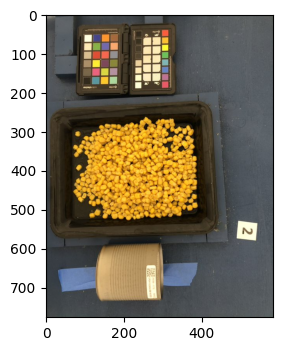

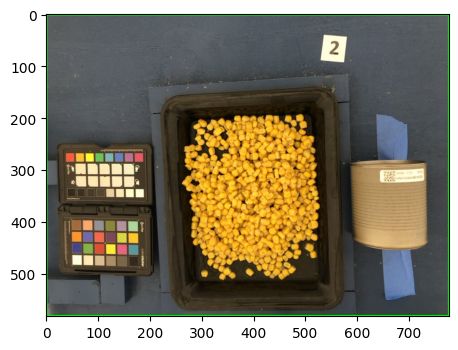

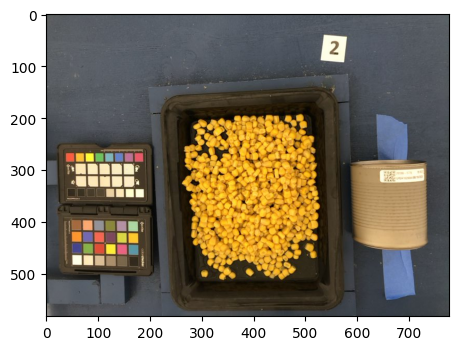

In [ ]:
# Pre-processing images

# Reading-in image(s)
img, path, filename = pcv.readimage(filename="/content/drive/MyDrive/Group_3_CSS844/OneDrive/OneDrive_IMG_0070.JPG")


# Flipping all images to landscape, 
# following https://note.nkmk.me/en/python-opencv-pillow-image-size/

# Assigning names to components of img.shape tuple (format h, w, c)

img_height, img_width, img_channel = img.shape 

# Code for flipping derived from: 
# https://note.nkmk.me/en/python-opencv-numpy-rotate-flip/, 
# https://www.geeksforgeeks.org/python-opencv-cv2-rotate-method/

if img_height > img_width: 
  img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)

corrected_img = pcv.white_balance(img, mode='hist', roi=None)

#corrected_img2 = pcv.white_balance(img2, mode='hist', roi=None)


## Defining function to white balance dataset:

## *(Props to Abby Bryson for writing this code for a past project and to Anne Steensma for tailoring it to this project!!)*

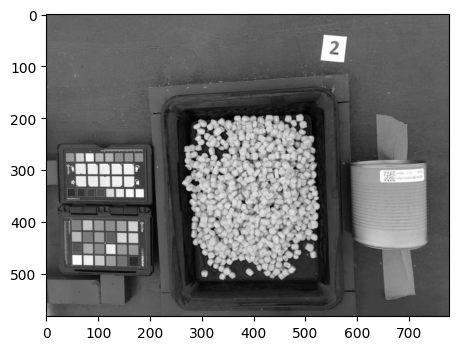

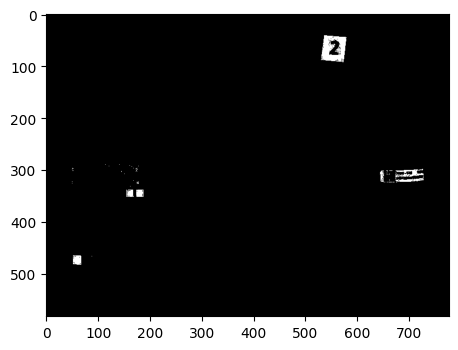

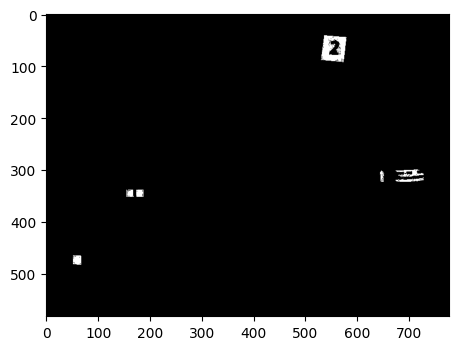

50 453

Locating best candidate location for white balancing...



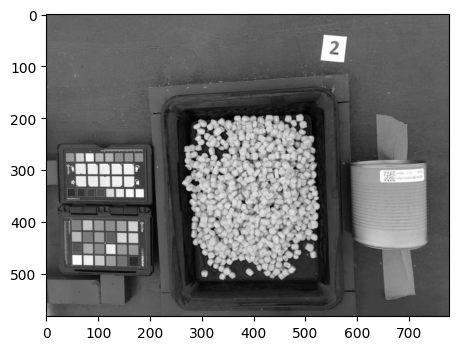

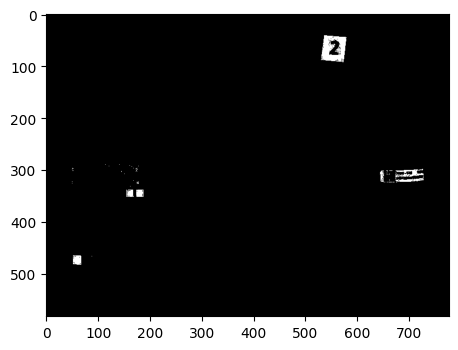

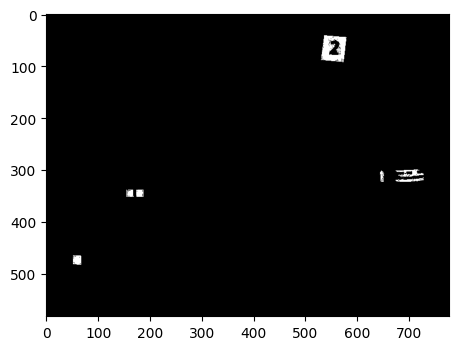

50 453

Top: original image:
Bottom: new image



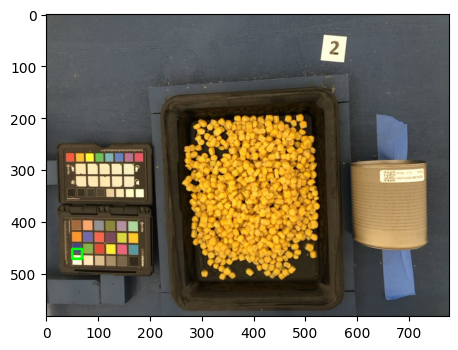

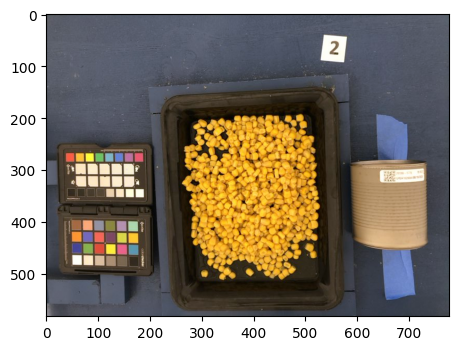

In [ ]:
def find_white_balance(tac):
    #pcv.plot_image(img)
    l = pcv.rgb2gray_lab(img, channel='l')
    #pcv.plot_image(l)
    find_tac = pcv.threshold.binary(l, threshold=249, max_value=255, object_type='light')
    img_height, img_width, img_channel = img.shape #added this line to allow for adjustment of coordinates based on different image sizes
    if (np.count_nonzero(find_tac) != 0): #changed from np.count_nonzero(img_binary) because it was giving "img_binary" not defined error
        tac = pcv.fill(find_tac, size=0.00008*(img_width*img_height)) #size = 1000 for large (4032 x 3024) images
        #tac = pcv.dilate(tac, 12, i=1) - commented this out as I think we did not need it
    #pcv.plot_image(tac)

    #find contours in the binary image
    contours, hierarchy = cv2.findContours(tac,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 
    for c in contours:
        M = cv2.moments(c)
        img_height, img_width, img_channel = img.shape
        cX = int(M["m10"] / M["m00"]) #looks like this line and the next one calculated the x/y coordinates of the object center (https://learnopencv.com/find-center-of-blob-centroid-using-opencv-cpp-python/)
        cY = int(M["m01"] / M["m00"])
        if (cX < 0.20*img_width and cY > 0.65*img_height): #<750 and >2000 for large images
          tac_center_X = int(cX - (0.007*img_width)) #changed from cX - 50
          if img_width < 4032: 
            tac_center_Y = int(cY - 0.017*img_width)  #correction for issues with smaller image (works for IMG 0070)
          else:
            tac_center_Y = cY #larger images do not seem to need the correction as much (not totally sure why)
            
    print(tac_center_X,tac_center_Y)        
    return (tac_center_X, tac_center_Y) 

find_white_balance(img)

print("\nLocating best candidate location for white balancing...\n")
White_Balance_X, White_Balance_Y = find_white_balance(img)
print("\nTop: original image:\nBottom: new image\n")
img_height, img_width, img_channel = img.shape
img = pcv.white_balance(img=img, roi=(White_Balance_X, White_Balance_Y, int(0.033*img_height), int(0.025*img_width)))# #formerly img = pcv.white_balance(img=img, roi=(White_Balance_X, White_Balance_Y, 100, 100))

## Segmenting the RGB Image:


Blue Channel Segmentation:



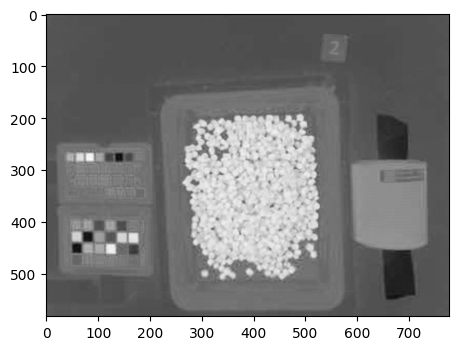

In [ ]:
# Segmenting the RGB image

print("\nBlue Channel Segmentation:\n")
b = pcv.rgb2gray_lab(img, channel='b')

## Creating our binary mask:

### (Commented lines are unnecessary for this notebook but may be helpful or necessary for future modifications)


First pass:



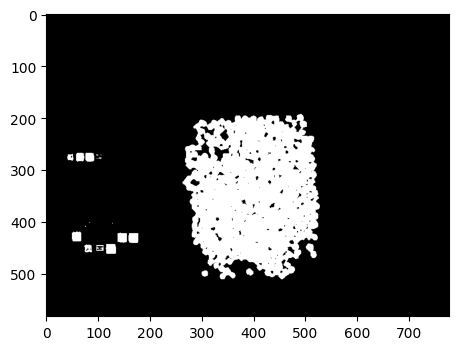

/nAfter blurring out some of the noise:



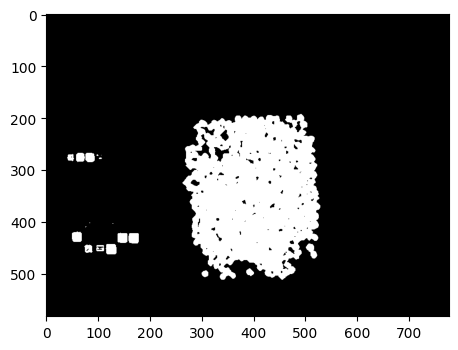


Mask applied to original image with 
white background for reference:



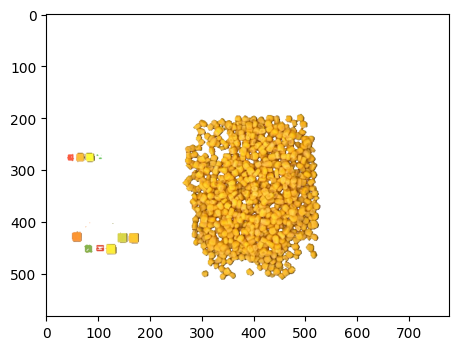

In [ ]:
print("\nFirst pass:\n")
img_binary = pcv.threshold.binary(b, threshold=170, max_value=255, object_type='light')

print("/nAfter blurring out some of the noise:\n")
b_mblur = pcv.median_blur(gray_img=img_binary, ksize=2)



##b2_mblur = pcv.median_blur(gray_img=img_binary, ksize=26)

#if (np.count_nonzero(img_binary) != 0):
    #img_binary = pcv.fill(b_mblur, size=250)
#if (np.count_nonzero(img_binary) != 0):
    #img2_binary = pcv.fill(b2_mblur, size=250)

#need to double check size and check that img_binary is the right file to save to here

#fill_image = pcv.fill_holes(bin_img=binary_img) [from tutorial for applying fill holes to a binary image]

#bb = pcv.logical_or(bin_img1=img_binary, bin_img2=img2_binary) # merging the two binary masks

print("\nMask applied to original image with ")
print("white background for reference:\n")
masked = pcv.apply_mask(img=img, mask=b_mblur, mask_color='white') 

#masked_black = pcv.apply_mask(img=img, mask=b_mblur, mask_color='black')

## Creating a mask that only captures the corn and not any color card or other noise:


Defining Region of Interest (blue box)...



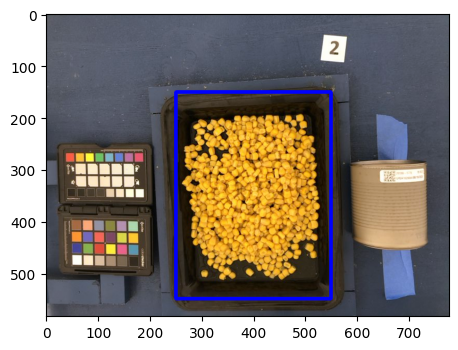


Using mask to assign objects...



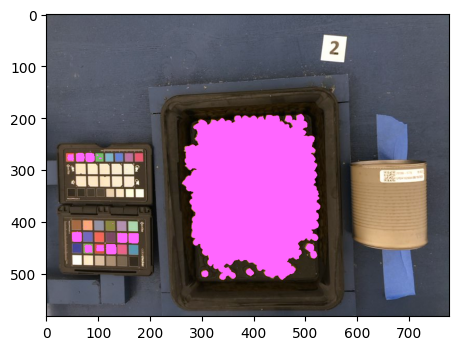


Discarding any objects outside the 
Region of Interest...



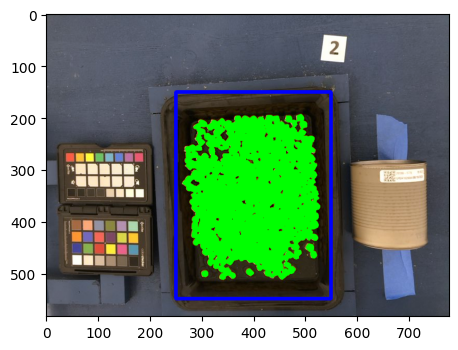

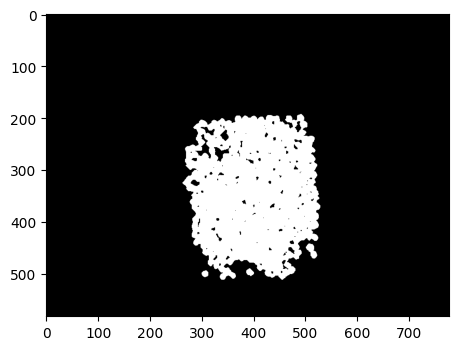


Saving mask to environment... 
(will output True if successful)




True

In [ ]:
# Define Region of Interest (roi)
# x and y coordinates are for upper left corner of rectangle

print("\nDefining Region of Interest (blue box)...\n")
# params: (img, top left corner x, top left corner y, height, width)
roi_contour, roi_hierarchy = pcv.roi.rectangle(img, x=250, y=150, h=400, w=300) 

print("\nUsing mask to assign objects...\n")
# Identify objects recognized within only the roi
id_objects, obj_hierarchy = pcv.find_objects(img=img, mask=b_mblur)

print("\nDiscarding any objects outside the ")
print("Region of Interest...\n")
# Exclude any object that is not within the roi
roi_objects, hierarchy3, kept_mask, obj_area = pcv.roi_objects(img=img, roi_contour=roi_contour, 
                                                               roi_hierarchy=roi_hierarchy, 
                                                               object_contour=id_objects, 
                                                               obj_hierarchy=obj_hierarchy,
                                                               roi_type='partial')

print("\nSaving mask to environment... ")
print("(will output True if successful)\n\n")
cv2.imwrite('kept_mask.png', kept_mask)

## Applying the mask to our original image, saving the result, using PlantCV to generate a histogram of colors in the original image, then generating a pseudo-colored image based on all of these results:

In [ ]:
print("\nSaving white-masked image ")
print("to environment...\n")
white_masked = pcv.apply_mask(img=img, mask=kept_mask, mask_color='white') 
cv2.imwrite('whitecornmask.png', white_masked)

print("\nCreating color histogram and ")
print("storing color data...\n")
analysis_image = pcv.analyze_color(rgb_img=img, mask=kept_mask, hist_plot_type='all', label="default")

hue_circular_mean = pcv.outputs.observations['default']['hue_circular_mean']['value']

print("\nGenerating pseudoimage to normalize ")
print("color distribution...\n")
print("(It's not really necessary for this ")
print("workflow but may be useful later)\n")
pseudo_img = pcv.visualize.pseudocolor(gray_img=b, obj=None, mask=kept_mask, cmap='viridis',
                                       min_value=0, max_value=255)

## Removing the background completely:

In [ ]:
from PIL import Image, ImageDraw, ImageFilter

print("\nNow we're going to make the background ")
print("transparent instead of white!\n")
print("\nThe resulting image won't be ")
print("plotted-to-screen in this notebook.")
print("\nInstead, the word 'True' will output to ")
print("screen if the file saved properly.\n")


# Input: masked image with white background
im_rgb = Image.open('/content/whitecornmask.png')

# Input: binary mask AFTER isolating Region of Interest
im_a = Image.open('/content/kept_mask.png').convert('L').resize(im_rgb.size)

# Output: masked image with transparent background
im_rgba = im_rgb.copy()
im_rgba.putalpha(im_a)
saved_transparent_image = im_rgba.save('transparent.png')

#Checking whether the file was created successfully
import os.path
file_exists = os.path.exists('transparent.png')
print(file_exists)

## Following [tutorial](https://github.com/kb22/Color-Identification-using-Machine-Learning/blob/master/Color%20Identification%20using%20Machine%20Learning.ipynb) to analyze most frequent colors in image and plotting those as hex codes in a pie chart:

In [ ]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
import cv2
from collections import Counter
from skimage.color import rgb2lab, deltaE_cie76
from array import array
import os

%matplotlib inline

# Leave cv2.IMREAD_UNCHANGED if using image with any transparency
image = cv2.imread('transparent.png', cv2.IMREAD_UNCHANGED) #changed from transparent2.png
print("The type of this input is {}".format(type(image)))
print("Shape: {}".format(image.shape))
plt.imshow(image)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_image, cmap='gray')

def RGB2HEX(color):
    return "#{:02x}{:02x}{:02x}".format(int(color[0]), int(color[1]), int(color[2]))

def get_image(image_path):
    # Leave cv2.IMREAD_UNCHANGED if using image with any transparency
    image = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def get_colors(image, number_of_colors, show_chart):
    modified_image = cv2.resize(image, (600, 400), interpolation = cv2.INTER_AREA)
    modified_image = modified_image.reshape(modified_image.shape[0]*modified_image.shape[1], 3)
    
    clf = KMeans(n_clusters = number_of_colors)
    labels = clf.fit_predict(modified_image)
    
    counts = Counter(labels)
    # sort to ensure correct color percentage
    counts = dict(sorted(counts.items()))
    
    center_colors = clf.cluster_centers_
    # We get ordered colors by iterating through the keys
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [RGB2HEX(ordered_colors[i]) for i in counts.keys()]
    rgb_colors = [ordered_colors[i] for i in counts.keys()]

    if (show_chart):
        plt.figure(figsize = (8, 6))
        plt.pie(counts.values(), labels = hex_colors, colors = hex_colors)
    
    return rgb_colors

# Plot results as pie chart
# Params: image_name.ext, # of colors you want to see, show chart T/F
get_colors(get_image('transparent.png'), 8, True) #changed from transparent2.png

#Get top colors and store data
#code pieces from #https://github.com/kb22/Color-Identification-using-Machine-Learning/blob/master/Color%20Identification%20using%20Machine%20Learning.ipynb that may help extract colors

image_colors = get_colors(get_image('transparent.png'), 4, False) #gets top "number_of_colors" colors from image. changed from transparent2.png

top_colors_list = []

list_to_iterate = list(range(number_of_colors))
del list_to_iterate[0] #removes first value (should correspond to white)

for i in list_to_iterate:
  curr_color = rgb2lab(np.uint8(np.asarray([[image_colors[i]]]))) #convert each non-white top color to comparable (LAB) format
  top_colors_list = [top_colors_list, curr_color]
    
print(top_colors_list)


# (End of Google Colab notebook)


In [ ]:
# Steps needed later to iterate over dataset as script

#class options:
#    def __init__(self):

#        self.image = "path/to/data" # Image path/name

#        self.debug = "plot" # Option "plot" prints each image to screen


#        self.writeimg= False # False because we do not want to save every image


#        self.result = "anything.json" # Results about shape analysis
                                                  #  are always written to a 
                                                  #  .json file


#        self.outdir = "." # Store the output to the current directory
        
# Get options
#args = options()

# Set debug to the global parameter 
#pcv.params.debug = args.debug